<a href="https://colab.research.google.com/github/brainer3220/COVID19_Forecast/blob/master/corona19_confirmed_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
 
import numpy as np

# Load Dataset

In [2]:
# Confirmation, recovery, and death data sets by region worldwide
# 전세계 지역별 확진자, 회복자, 사망자 Data Set
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
data = pd.read_csv(url, error_bad_lines=False)

# Understanding the structure of the data set
# Data Set의 구조 파악
data.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,11/12/21,11/13/21,11/14/21,11/15/21,11/16/21,11/17/21,11/18/21,11/19/21,11/20/21,11/21/21,11/22/21,11/23/21,11/24/21,11/25/21,11/26/21,11/27/21,11/28/21,11/29/21,11/30/21,12/1/21,12/2/21,12/3/21,12/4/21,12/5/21,12/6/21,12/7/21,12/8/21,12/9/21,12/10/21,12/11/21,12/12/21,12/13/21,12/14/21,12/15/21,12/16/21,12/17/21,12/18/21,12/19/21,12/20/21,12/21/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,5,...,156487,156510,156552,156610,156649,156739,156739,156812,156864,156896,156911,157015,157032,157144,157171,157190,157218,157260,157289,157359,157387,157412,157431,157445,157499,157508,157542,157585,157858,157858,157858,157648,157660,157665,157725,157734,157745,157787,157795,157816
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,192013,192600,193075,193269,193856,194472,195021,195523,195988,195988,196611,197167,197776,198292,198732,199137,199555,199750,199945,200173,200639,201045,201402,201730,201902,202295,202641,202863,203215,203524,203787,203925,204301,204627,204928,205224,205549,205777,205897,206273
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,207764,207873,207970,208104,208245,208380,208532,208695,208839,208952,209111,209283,209463,209624,209817,209980,210152,210344,210531,210723,210921,211112,211297,211469,211662,211859,212047,212224,212434,212652,212848,213058,213288,213533,213745,214044,214330,214592,214835,215145
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15819,15819,15819,15907,15929,15972,16035,16086,16086,16086,16299,16342,16426,16566,16712,16712,16712,16712,17115,17426,17658,18010,18010,18010,18631,18815,18815,19272,19440,19440,19440,19440,20136,20136,20549,20549,20549,20549,21062,21062
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,64875,64899,64913,64913,64940,64968,64985,64997,65011,65024,65033,65061,65080,65105,65130,65139,65144,65155,65168,65183,65208,65223,65244,65259,65259,65301,65332,65346,65371,65397,65404,65404,65431,65565,65648,65760,65868,65938,66086,66566


# Make it Simple

In [3]:
# Make Korea's confirmed cases timeseries dataframe
# 한국의 확진자 시계열 데이터프레임를 확인합니다

df_korea = data[data['Country/Region'] == 'Korea, South']
df_korea = df_korea.T[4:]

df_korea = df_korea.reset_index().rename(columns={'index': 'date', 160: 'confirmed'})

df_korea.tail()

,date,confirmed
695,12/17/21,558864
696,12/18/21,565098
697,12/19/21,570414
698,12/20/21,575615
699,12/21/21,583065


# Plot

In [4]:
# Plot Korean COVID19 confirmed cases.
# 한국 코로나19 확진자 트렌드를 그래프로 만듭니다.

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df_korea.date,
        y=df_korea.confirmed,
        name='Confirmed in Korea'
    )
)

fig

# Facebook Prophet

In [5]:
# Make dataframe for Facebook Prophet prediction model.
# Facebook Prophet 예측 모델에 넣을 데이터프레임을 만들어줍니다.
df_prophet = df_korea.rename(columns={
    'date': 'ds',
    'confirmed': 'y'
})

df_prophet.tail()

,ds,y
695,12/17/21,558864
696,12/18/21,565098
697,12/19/21,570414
698,12/20/21,575615
699,12/21/21,583065


# Create a Model

# Add changepoints to Make More Flexible
- https://facebook.github.io/prophet/docs/trend_changepoints.html

In [6]:
# Make Prophet model including daily seasonality
# Prophet에서 감안할 계절성을 선택해서 모델을 만듭니다
m = Prophet(
    changepoint_prior_scale=0.5, # increasing it will make the trend more flexible
    changepoint_range=0.95, # place potential changepoints in the first 98% of the time series
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=True,
    seasonality_mode='additive'
)

m.fit(df_prophet)

future = m.make_future_dataframe(periods=7)
forecast = m.predict(future)

fig = plot_plotly(m, forecast)
py.iplot(fig)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


# Plot changepoints

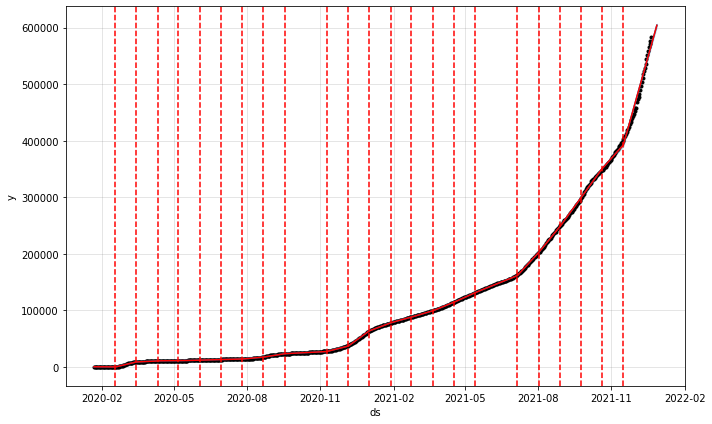

In [7]:
# display changepoints as red dotted line on the plot.
# changepoint를 그래프에 반영해봅시다.
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [8]:
day_confirmed = pd.DataFrame(np.array(df_korea.confirmed) - np.array(pd.concat([pd.DataFrame([0]), df_korea.confirmed[:-1]])).reshape(-1))
day_confirmed.columns = ["y"]

ds = df_prophet['ds']
day_confirmed = pd.concat([ds, day_confirmed], axis=1)
day_confirmed

,ds,y
0,1/22/20,1
1,1/23/20,0
2,1/24/20,1
3,1/25/20,0
4,1/26/20,1
...,...,...
695,12/17/21,7313
696,12/18/21,6234
697,12/19/21,5316
698,12/20/21,5201


In [9]:
# day_confirmed = pd.DataFrame(np.array(df_korea.confirmed) - np.array(pd.concat([pd.DataFrame([0]), df_korea.confirmed[:-1]])).reshape(-1))


m = Prophet(
    changepoint_prior_scale=0.6, # increasing it will make the trend more flexible
    changepoint_range=0.97, # place potential changepoints in the first 98% of the time series
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=True,
    seasonality_mode='additive'
)

m.fit(day_confirmed)

future = m.make_future_dataframe(periods=31)
forecast = m.predict(future)

fig = plot_plotly(m, forecast)
py.iplot(fig)

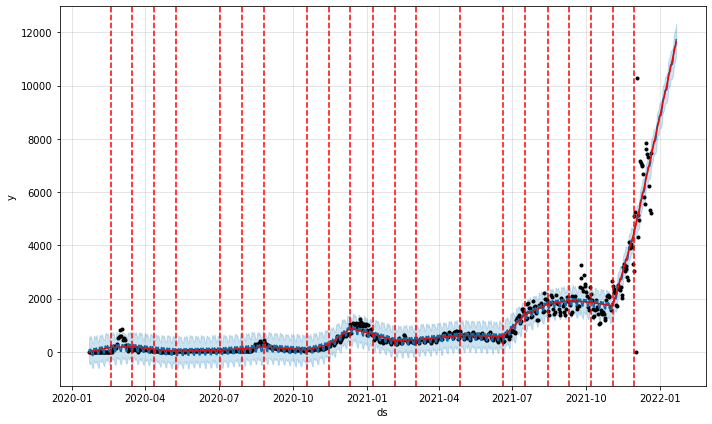

In [10]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)